<a href="https://colab.research.google.com/github/Neeshalmr/CNN/blob/main/Copy_of_Malware_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !wget "https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47&confirm=t"
# !mv "$(ls -Art | head -1)" mal.zip

!pip install gdown
#upgrade
!pip install --upgrade gdown

import gdown
# a file
url = "https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47"
output = "mal.zip"
gdown.download(url, output)

!unzip -o mal.zip
!rm mal_data/train/.DS_Store
!rm mal_data/test/.DS_Store

Downloading...
From (original): https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47
From (redirected): https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47&confirm=t&uuid=4686ad0d-e23e-4df2-b071-8e0c03a1c384
To: /content/mal.zip
100%|██████████| 2.44G/2.44G [00:27<00:00, 88.3MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: mal_data/train/Zbot/49f9785d5a42b3daa95d7d91ab077e669f7116c8.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._49f9785d5a42b3daa95d7d91ab077e669f7116c8.exe  
  inflating: mal_data/train/Zbot/daf40516a7c465ebbcaea190707a04bf6af1a2e5.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._daf40516a7c465ebbcaea190707a04bf6af1a2e5.exe  
  inflating: mal_data/train/Zbot/42547c95702e0c5c846e4e5ecac6db6ac8c22175.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._42547c95702e0c5c846e4e5ecac6db6ac8c22175.exe  
  inflating: mal_data/train/Zbot/39940afa60287af35d90db68fc6396d0c20b74d0.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._39940afa60287af35d90db68fc6396d0c20b74d0.exe  
  inflating: mal_data/train/Zbot/d7c51263bd3beec0fcefa2d94589530450b5e1bd.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._d7c51263bd3beec0fcefa2d94589530450b5e1bd.exe  
  inflating: mal_data/train/Zbot/21891ae5ca1d7146a8df57aa7c89b7234b099ff7.exe  
  inflating: _

In [2]:
import os
import pickle

import numpy as np

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.
    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

_,class_to_idx = find_classes("mal_data/train")


class MalwareDataset(Dataset):
    def __init__(self, data_path, input_length = 4096, transform=False):
        self.data_path = data_path
        self.input_length = input_length
        _,self.class_to_idx = find_classes(data_path)
        self.malware_files = []
        available_classes = set()
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(data_path, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.malware_files.append(item)

    def __getitem__(self, index):
        item = self.malware_files[index]
        with open(item[0], "rb") as f:
            tmp = [i+1 for i in f.read()[:self.input_length]]
            tmp = tmp+[0]*(self.input_length-len(tmp))
        return np.array(tmp), item[1]

    def __len__(self):
        return len(self.malware_files)



In [3]:
import torch
from torch import nn
from torch.nn import functional as F


# neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv1d(1,4,19,5),
            nn.MaxPool1d(4),
            nn.Flatten(),
            nn.Linear(48, 6)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()


lr=0.001
num_epochs=10
batch_size = 16
input_len = 256 # Number of bytes read from application files (.exe)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_data = MalwareDataset("mal_data/train",input_length = input_len)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = MalwareDataset("mal_data/test",input_length = input_len)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

loss_list = []
acc_list = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (samples, labels) in enumerate(train_loader):
    samples = samples.type(torch.FloatTensor).cuda()
    labels = labels.cuda()

    outputs = model(samples.unsqueeze(1))

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%200 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
# -------------------------
# FGSM Adversarial Attack
# -------------------------

def fgsm_attack(model, loss_fn, x, y, epsilon):
    """
    Generates FGSM adversarial examples.
    x: input batch (FloatTensor)
    y: correct labels (LongTensor)
    """
    x_adv = x.clone().detach().cuda().requires_grad_(True)
    outputs = model(x_adv.unsqueeze(1))
    loss = loss_fn(outputs, y)

    # Compute gradients w.r.t. input
    model.zero_grad()
    loss.backward()

    # Generate adversarial sample
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 255)  # ensure valid byte range

    return x_adv.detach()

# -------------------------
# Evaluate model on clean vs adversarial samples
# -------------------------

def evaluate_clean_and_adversarial(model, data_loader, epsilon):
    model.eval()
    correct_clean, correct_adv = 0, 0
    total = 0

    for x, y in data_loader:
        x = x.type(torch.FloatTensor).cuda()
        y = y.cuda()
        total += y.size(0)

        # Clean prediction
        outputs = model(x.unsqueeze(1))
        _, pred_clean = torch.max(outputs.data, 1)
        correct_clean += (pred_clean == y).sum().item()

        # Generate adversarial examples
        x_adv = fgsm_attack(model, criterion, x, y, epsilon)
        outputs_adv = model(x_adv.unsqueeze(1))
        _, pred_adv = torch.max(outputs_adv.data, 1)
        correct_adv += (pred_adv == y).sum().item()

    acc_clean = 100 * correct_clean / total
    acc_adv = 100 * correct_adv / total

    print(f"\n--- Evaluation Results (epsilon={epsilon}) ---")
    print(f"Clean Accuracy:       {acc_clean:.2f}%")
    print(f"Adversarial Accuracy: {acc_adv:.2f}%")
    print(f"Attack Success Rate:  {100 - acc_adv:.2f}%")

    return acc_clean, acc_adv

# -------------------------
# Run the attack
# -------------------------

epsilon = 1.0   # strength of adversarial perturbation
evaluate_clean_and_adversarial(model, test_loader, epsilon)



Epoch [1/10], Step [0/437], Loss: 21.7289, Accuracy: 31.25%
Epoch [1/10], Step [200/437], Loss: 1.4605, Accuracy: 75.00%
Epoch [1/10], Step [400/437], Loss: 0.3347, Accuracy: 87.50%
Epoch [2/10], Step [0/437], Loss: 0.7772, Accuracy: 87.50%
Epoch [2/10], Step [200/437], Loss: 0.5688, Accuracy: 81.25%
Epoch [2/10], Step [400/437], Loss: 0.8349, Accuracy: 87.50%
Epoch [3/10], Step [0/437], Loss: 0.2162, Accuracy: 100.00%
Epoch [3/10], Step [200/437], Loss: 0.5391, Accuracy: 75.00%
Epoch [3/10], Step [400/437], Loss: 0.0805, Accuracy: 100.00%
Epoch [4/10], Step [0/437], Loss: 0.5507, Accuracy: 87.50%
Epoch [4/10], Step [200/437], Loss: 0.2810, Accuracy: 93.75%
Epoch [4/10], Step [400/437], Loss: 0.1402, Accuracy: 93.75%
Epoch [5/10], Step [0/437], Loss: 0.1120, Accuracy: 100.00%
Epoch [5/10], Step [200/437], Loss: 0.4620, Accuracy: 81.25%
Epoch [5/10], Step [400/437], Loss: 0.7693, Accuracy: 81.25%
Epoch [6/10], Step [0/437], Loss: 0.2610, Accuracy: 93.75%
Epoch [6/10], Step [200/437], Lo

(91.34068873286526, 66.96756937479104)

In [4]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for samples, labels in test_loader:
      samples = samples.type(torch.FloatTensor).cuda()
      labels = labels.cuda()

      outputs = model(samples.unsqueeze(1))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the test samples: {} %'.format((correct / total) * 100))

Accuracy of the model on the test samples: 91.34068873286526 %


In [5]:
# --------------------------------------------------------
# FGSM Adversarial Attack Implementation
# --------------------------------------------------------

def fgsm_attack(model, loss_fn, x, y, epsilon):
    """
    Generate FGSM adversarial examples.
    x: input batch (FloatTensor)
    y: correct labels (LongTensor)
    """
    x_adv = x.clone().detach().cuda()
    x_adv.requires_grad = True

    # Forward pass
    outputs = model(x_adv.unsqueeze(1))
    loss = loss_fn(outputs, y)

    # Backward pass: compute gradient on inputs
    model.zero_grad()
    loss.backward()

    # FGSM update: move each byte by epsilon in gradient direction
    x_adv = x_adv + epsilon * x_adv.grad.sign()

    # Clamp byte values to valid range 0–255
    x_adv = torch.clamp(x_adv, 0, 255)

    return x_adv.detach()

# --------------------------------------------------------
# Evaluate model on CLEAN vs ADVERSARIAL samples
# --------------------------------------------------------

def evaluate_clean_vs_adv(model, data_loader, epsilon):
    model.eval()
    correct_clean = 0
    correct_adv = 0
    total = 0

    for samples, labels in data_loader:
        samples = samples.type(torch.FloatTensor).cuda()
        labels = labels.cuda()
        total += labels.size(0)

        # ----- Clean predictions -----
        outputs = model(samples.unsqueeze(1))
        _, pred_clean = torch.max(outputs.data, 1)
        correct_clean += (pred_clean == labels).sum().item()

        # ----- Adversarial predictions -----
        adv_samples = fgsm_attack(model, criterion, samples, labels, epsilon)
        outputs_adv = model(adv_samples.unsqueeze(1))
        _, pred_adv = torch.max(outputs_adv.data, 1)
        correct_adv += (pred_adv == labels).sum().item()

    clean_acc = 100 * correct_clean / total
    adv_acc = 100 * correct_adv / total

    print(f"\n========== FGSM Attack Results (epsilon={epsilon}) ==========")
    print(f"Clean Accuracy:        {clean_acc:.2f}%")
    print(f"Adversarial Accuracy:  {adv_acc:.2f}%")
    print(f"Attack Success Rate:   {100 - adv_acc:.2f}%")
    print("=============================================================\n")

    return clean_acc, adv_acc

# --------------------------------------------------------
# Run FGSM attack on your trained model
# --------------------------------------------------------

epsilon = 1.0   # You may try values like 0.1, 0.5, 1.0, 2.0
evaluate_clean_vs_adv(model, test_loader, epsilon)



========== FGSM Attack Results (epsilon=1.0) ==========
Clean Accuracy:        91.34%
Adversarial Accuracy:  66.97%
Attack Success Rate:   33.03%



(91.34068873286526, 66.96756937479104)

Text(0.5, 1.0, 'loss')

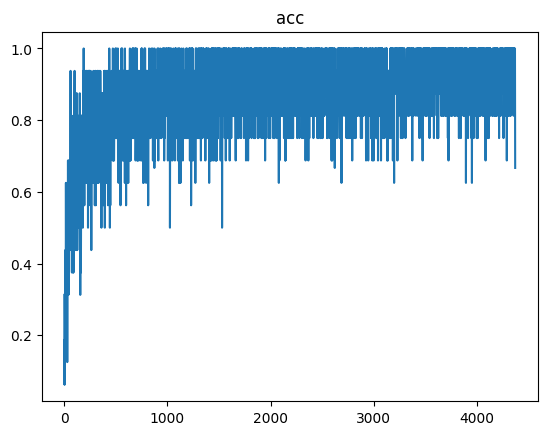

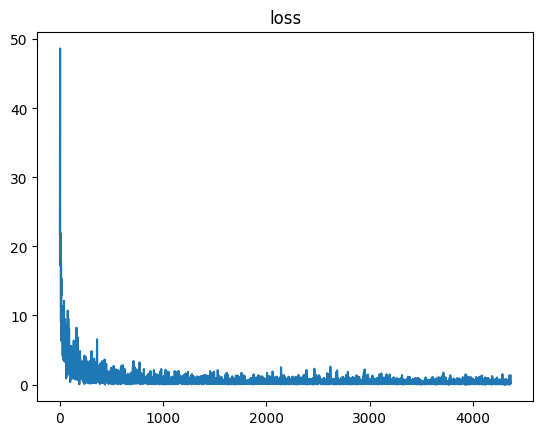

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc_list)
plt.title('acc')

plt.figure()
plt.plot(loss_list)
plt.title('loss')



Paper for reference:
https://arxiv.org/pdf/1710.09435v1.pdf
